In [1]:
!wget http://launchpadlibrarian.net/367274644/libgoogle-perftools-dev_2.5-2.2ubuntu3_amd64.deb
!wget https://launchpad.net/ubuntu/+source/google-perftools/2.5-2.2ubuntu3/+build/14795286/+files/google-perftools_2.5-2.2ubuntu3_all.deb
!wget https://launchpad.net/ubuntu/+source/google-perftools/2.5-2.2ubuntu3/+build/14795286/+files/libtcmalloc-minimal4_2.5-2.2ubuntu3_amd64.deb
!wget https://launchpad.net/ubuntu/+source/google-perftools/2.5-2.2ubuntu3/+build/14795286/+files/libgoogle-perftools4_2.5-2.2ubuntu3_amd64.deb
!apt install -qq libunwind8-dev
!dpkg -i *.deb
%env LD_PRELOAD=libtcmalloc.so

--2023-08-02 19:36:16--  http://launchpadlibrarian.net/367274644/libgoogle-perftools-dev_2.5-2.2ubuntu3_amd64.deb
Resolving launchpadlibrarian.net (launchpadlibrarian.net)... 185.125.189.228, 185.125.189.229, 2620:2d:4000:1001::8008, ...
Connecting to launchpadlibrarian.net (launchpadlibrarian.net)|185.125.189.228|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203696 (199K) [application/x-debian-package]
Saving to: ‘libgoogle-perftools-dev_2.5-2.2ubuntu3_amd64.deb.1’

libgoogle-perftools 100%[===================>] 198.92K   545KB/s    in 0.4s    

2023-08-02 19:36:17 (545 KB/s) - ‘libgoogle-perftools-dev_2.5-2.2ubuntu3_amd64.deb.1’ saved [203696/203696]

--2023-08-02 19:36:17--  https://launchpad.net/ubuntu/+source/google-perftools/2.5-2.2ubuntu3/+build/14795286/+files/google-perftools_2.5-2.2ubuntu3_all.deb
Resolving launchpad.net (launchpad.net)... 185.125.189.222, 185.125.189.223, 2620:2d:4000:1001::8003, ...
Connecting to launchpad.net (launchpad.net)|185.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_path = '/content/drive/MyDrive/BERT/'

In [16]:
#import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

<h1 style="font-size:200%; font-family:cursive; color:navy;">1. Import Required Libraries & Dataset</h1>

In [4]:
#!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl
#!pip install cloud-tpu-client==0.10 torch==2.0.0  torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/117/torch_xla-2.0-cp39-cp39-linux_x86_64.whl --force-reinstall

%pip install transformers

In [5]:
import numpy as np
import pandas as pd
from babel.dates import format_date, format_datetime, format_time
from datetime import date, datetime, time
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast

# imports the torch_xla package
#import torch_xla
#import torch_xla.core.xla_model as xm


In [6]:
print(torch.cuda.is_available())

True


In [7]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Creates a random tensor on xla:1 (a Cloud TPU core)
#device = xm.xla_device()
#t1 = torch.ones(3, 3, device = device)
#print(t1)

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:416: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [8]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


In [9]:
printm()

Gen RAM Free: 25.4 GB  | Proc size: 578.3 MB
GPU RAM Free: 15098MB | Used: 3MB | Util   0% | Total 15360MB


<h1 style="font-size:200%; font-family:cursive; color:navy;">3. Import Bert - base- uncased</h1>

In [10]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('zhihan1996/DNA_bert_6')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('zhihan1996/DNA_bert_6')

In [11]:
import pickle

#drive_path = "C:/Users/bromotdi/BERT/"
# with open(drive_path + 'train_text.pkl', 'rb') as f:
#     train_text = pickle.load(f)
# with open(drive_path + 'temp_text.pkl', 'rb') as f:
#     temp_text = pickle.load(f)
with open(drive_path + 'train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)
# with open(drive_path + 'temp_labels.pkl', 'rb') as f:
#     temp_labels = pickle.load(f)

# with open(drive_path + 'val_text.pkl', 'rb') as f:
#     val_text = pickle.load(f)
# with open(drive_path + 'test_text.pkl', 'rb') as f:
#     test_text = pickle.load(f)
with open(drive_path + 'val_labels.pkl', 'rb') as f:
    val_labels = pickle.load(f)
with open(drive_path + 'test_labels.pkl', 'rb') as f:
    test_labels = pickle.load(f)

<h1 style="font-size:200%; font-family:cursive; color:navy;">4. Tokenize & Encode the Sequences</h1>

<u><h2 style="font-size:170%; font-family:cursive;">Which Tokenization strategy is used by BERT?</h2></u>

<p style="font-size:150%; font-family:verdana;">BERT uses WordPiece tokenization. The vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the existing words in the vocabulary are iteratively added.</p>
<br>
<u><h2 style="font-size:170%; font-family:cursive;">What is the maximum sequence length of the input?</h2></u>

<p style="font-size:150%; font-family:verdana;">The maximum sequence length of the input = 512</p>

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
with open(drive_path + 'tokens_train.pkl', 'wb') as f:
    pickle.dump(tokens_train, f)

In [ ]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
with open(drive_path + 'tokens_val.pkl', 'wb') as f:
    pickle.dump(tokens_val, f)

In [ ]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
with open(drive_path + 'tokens_test.pkl', 'wb') as f:
    pickle.dump(tokens_test, f)

# Load Tokens

In [12]:
with open(drive_path + 'tokens_train.pkl', 'rb') as f:
    tokens_train = pickle.load(f)
with open(drive_path + 'tokens_val.pkl', 'rb') as f:
    tokens_val = pickle.load(f)
#with open(drive_path + 'tokens_test.pkl', 'rb') as f:
#    tokens_test = pickle.load(f)


<h1 style="font-size:200%; font-family:cursive; color:navy;">5. List to Tensors</h1>

In [13]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

#test_seq = torch.tensor(tokens_test['input_ids'])
#test_mask = torch.tensor(tokens_test['attention_mask'])
#test_y = torch.tensor(test_labels.tolist())

Clear token variables as they are no longer needed.

In [14]:
del tokens_train, tokens_val #, tokens_test

<h1 style="font-size:200%; font-family:cursive; color:navy;">6. Data Loader</h1>

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

<h1 style="font-size:200%; font-family:cursive; color:navy;">7. Model Architecture</h1>

In [16]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [17]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,10)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [18]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [19]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
from sklearn.utils.class_weight import compute_class_weight
print(np.unique(train_labels))
#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(train_labels), y = train_labels)

print("Class Weights:",class_weights)

[0 1 2 3 4 5 6 7 8 9]
Class Weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [21]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10000

<h1 style="font-size:200%; font-family:cursive; color:navy;">8. Fine - Tune</h1>

In [22]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.detach()#total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss.item() / len(train_dataloader) #total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [23]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.detach()#total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss.item() / len(val_dataloader) #total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [24]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    #save the best model
    if epoch % 10 == 0 and valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), drive_path + 'saved_weights_10000_uncase.pkl')
        with open(drive_path + 'train_losses.pkl', 'wb') as f:
            pickle.dump(train_losses, f)
        with open(drive_path + 'valid_losses.pkl', 'wb') as f:
            pickle.dump(valid_losses, f)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

Streaming output truncated to the last 5000 lines.

Evaluating...

Training Loss: 1.982
Validation Loss: 2.151

 Epoch 9446 / 10000
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 1.981
Validation Loss: 2.150

 Epoch 9447 / 10000
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 1.991
Validation Loss: 2.149

 Epoch 9448 / 10000
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 1.988
Validation Loss: 2.148

 Epoch 9449 / 10000
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 1.993
Validation Loss: 2.149

 Epoch 9450 / 10000
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 1.987
Validation Loss: 2.149

 Epoch 9451 / 10000
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 1.986
Validation Loss: 2.151

 Epoch 9452 / 10000
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Tr

In [ ]:
del train_seq, train_mask, train_y
del val_seq, val_mask, val_y

In [ ]:
del train_losses, valid_losses

In [18]:
import pickle

In [19]:
t_load = False
v_load = False

try:
    # Try to access train_losses
    if len(train_losses) > 0:
        # Do something with train_losses if it exists and is not empty
        print("train_losses is defined and has a length greater than 0.")
    else:
        # Do something else when train_losses is defined but empty
        print("train_losses is defined, but it is empty.")
except NameError:
    # Handle the case when train_losses is not defined
    train_losses = []
    t_load = True

try:
    # Try to access valid_losses
    if len(valid_losses) > 0:
        # Do something with valid_losses if it exists and is not empty
        print("valid_losses is defined and has a length greater than 0.")
    else:
        # Do something else when valid_losses is defined but empty
        print("valid_losses is defined, but it is empty.")
except NameError:
    # Handle the case when valid_losses is not defined
    valid_losses = []
    v_load = True

if t_load:
    with open(drive_path + 'train_losses.pkl', 'rb') as f:
        train_losses = pickle.load(f)
if v_load:
    with open(drive_path + 'valid_losses.pkl', 'rb') as f:
        valid_losses = pickle.load(f)

In [23]:
import matplotlib.pyplot as plt
import numpy as np

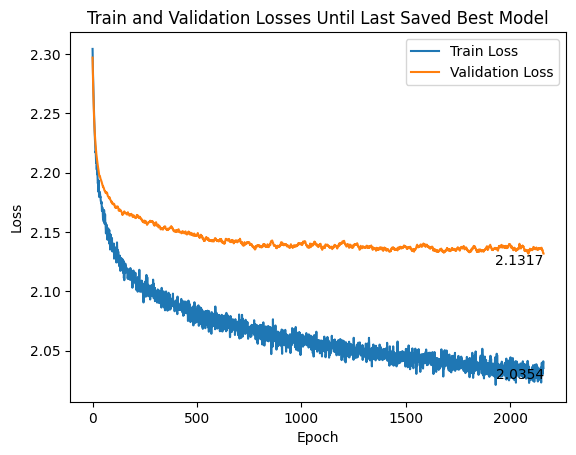

In [30]:
# Plot train_losses and valid_losses against their indices
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')

last_train_loss = round(train_losses[-1], 4)
last_valid_loss = round(valid_losses[-1], 4)

plt.text(len(train_losses), train_losses[-1], str(last_train_loss), ha='right', va='top')
plt.text(len(valid_losses), valid_losses[-1], str(last_valid_loss), ha='right', va='top')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses Until Last Saved Best Model')

# Add a legend to differentiate train and validation losses
plt.legend()

# Show the plot
plt.show()

In [ ]:
#load weights of best model

path = drive_path + "temp_labels.pkl/saved_weights_10000_uncase.pkl"
model.load_state_dict(torch.load(path))

<h1 style="font-size:200%; font-family:cursive; color:navy;">9. Make Predictions</h1>

In [ ]:
with open(drive_path + 'tokens_test.pkl', 'rb') as f:
    tokens_test = pickle.load(f)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

del tokens_test

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
from sklearn.metrics import classification_report

# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.26      0.11      0.15        75
           1       0.37      0.37      0.37        75
           2       0.18      0.11      0.13        75
           3       0.17      0.24      0.20        75
           4       0.14      0.47      0.22        75
           5       0.17      0.05      0.08        75
           6       0.19      0.17      0.18        75
           7       0.20      0.28      0.24        75
           8       0.43      0.21      0.29        75
           9       0.33      0.05      0.09        75

    accuracy                           0.21       750
   macro avg       0.25      0.21      0.19       750
weighted avg       0.25      0.21      0.19       750



<center><h1 style="font-size:300%; font-family:cursive; color:black; background:skyblue; padding:15px; border:solid;">REFERENCES & CREDITS</h1></center>

<ol>
    <li style="font-size:150%;"><a href="https://www.reddit.com/r/MachineLearning/comments/ao23cp/p_how_to_use_bert_in_kaggle_competitions_a/">How to use BERT in Kaggle competitions - Reddit Thread</a></li>
    <li style="font-size:150%;"><a href="http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">A visual guide to using BERT by Jay Alammar</a></li>
    <li style="font-size:150%;"><a href="https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/">Demystifying BERT: Groundbreaking NLP Framework by Mohd Sanad Zaki Rizvi</a></li>
    <li style="font-size:150%;"><a href="https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03">BERT for Dummies step by step tutorial by Michel Kana</a></li>
</ol>

<br>
<center><h1 style="font-size:300%; font-family:cursive; color:black; background:skyblue; padding:15px; border:solid;">CONCLUSION</h1></center>

<p style="font-size:150%; font-family:verdana;">BERT is undoubtedly a breakthrough in the use of Machine Learning for Natural Language Processing. The fact that it’s approachable and allows fast fine-tuning will likely allow a wide range of practical applications in the future. In this Notebook we have discussed about BERT (Theoritical + Practical Part).</p>

<center><h1 style="font-size:200%; color:green;">Please give this kernel an UPVOTE to show your appreciation, if you find it useful.</h1></center>